In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import mnist_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible

In [4]:
X_train, X_val, y_train, y_val = mnist_prep()

In [5]:
# use samller dataset for increased speed
X_train_small = X_train[:1000, :]
X_val_small = X_val[:500, :]
y_train_small = y_train[:1000]
y_val_small = y_val[:500]

n_cols = X_train_small.shape[1]

# EnKF

In [6]:
X_train = X_train_small
X_test = X_val_small
y_train = y_train_small
y_test = y_val_small

In [7]:
batch_size = 50
epochs = 5
particles = 10
early_stopping = 0.001
batch_normal = False # noch einbauen, aber Achtung mit den Dimensionen unten!!!
shuffle = True

In [8]:
layers = 5
neurons = [128, 128, 64, 32, 10]
n_cols = X_train.shape[1]

In [9]:
delta = 0.005
h_0 = 2
epsilon = 0.5

In [10]:
n = len(X_train)
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [11]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_acc_dict = {}
test_acc_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [12]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_acc_dict["model_{}".format(str(i+1))] = []
    test_acc_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [13]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_val_small, y_val_small)[1])

16/16 [==============================] - 0s 2ms/step - loss: 2.3805 - accuracy: 0.1140
0.11400000005960464
16/16 [==============================] - 0s 2ms/step - loss: 2.4470 - accuracy: 0.0700
0.07000000029802322
16/16 [==============================] - 0s 2ms/step - loss: 2.3891 - accuracy: 0.0820
0.0820000022649765
16/16 [==============================] - 0s 2ms/step - loss: 2.4278 - accuracy: 0.1240
0.12399999797344208
16/16 [==============================] - 0s 2ms/step - loss: 2.4027 - accuracy: 0.1060
0.10599999874830246
16/16 [==============================] - 0s 2ms/step - loss: 2.4314 - accuracy: 0.0720
0.07199999690055847
16/16 [==============================] - 0s 2ms/step - loss: 2.3707 - accuracy: 0.0920
0.09200000017881393
16/16 [==============================] - 0s 2ms/step - loss: 2.5079 - accuracy: 0.0680
0.06800000369548798
16/16 [==============================] - 0s 2ms/step - loss: 2.4219 - accuracy: 0.1140
0.11400000005960464
16/16 [==============================]

In [14]:
import time
start_time = time.time()

In [15]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [X_train[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]   
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            jacobian_dict["model_{}".format(str(i+1))] = (-1) * np.multiply(np.array(y_batches[b]), 
                                                                            np.array(1 / (y_pred_dict["model_{}".format(str(i+1))] + delta)))
            
            # for every particle write the training accuracy of the current iteration in a dictionary
            train_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])
            
            # for every particle write the test accuracy of the current iteration in a dictionary
            test_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])
            
            # for every particle write the current iteration in a dictionary
            iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
        #print(y_pred_dict["model_1"])
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))
                                       
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))

In [16]:
end_time = time.time()
print("Calculation time: {}".format(end_time - start_time))

Calculation time: 262.94253373146057


In [17]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_val_small, y_val_small)[1])

16/16 [==============================] - 0s 2ms/step - loss: 2.3061 - accuracy: 0.0900
0.09000000357627869
16/16 [==============================] - 0s 2ms/step - loss: 2.3089 - accuracy: 0.0900
0.09000000357627869
16/16 [==============================] - 0s 2ms/step - loss: 2.3052 - accuracy: 0.0900
0.09000000357627869
16/16 [==============================] - 0s 2ms/step - loss: 2.3079 - accuracy: 0.0900
0.09000000357627869
16/16 [==============================] - 0s 2ms/step - loss: 2.3071 - accuracy: 0.0900
0.09000000357627869
16/16 [==============================] - 0s 2ms/step - loss: 2.3097 - accuracy: 0.0880
0.08799999952316284
16/16 [==============================] - 0s 1ms/step - loss: 2.3048 - accuracy: 0.0900
0.09000000357627869
16/16 [==============================] - 0s 2ms/step - loss: 2.3064 - accuracy: 0.0900
0.09000000357627869
16/16 [==============================] - 0s 2ms/step - loss: 3.5012 - accuracy: 0.0660
0.06599999964237213
16/16 [==============================

In [18]:
model_dict

{'model_1': <tensorflow.python.keras.engine.sequential.Sequential at 0x19d0d266cc8>,
 'model_2': <tensorflow.python.keras.engine.sequential.Sequential at 0x19d0d28d708>,
 'model_3': <tensorflow.python.keras.engine.sequential.Sequential at 0x19d0d2c1848>,
 'model_4': <tensorflow.python.keras.engine.sequential.Sequential at 0x19d0d2f0ac8>,
 'model_5': <tensorflow.python.keras.engine.sequential.Sequential at 0x19d0d321c48>,
 'model_6': <tensorflow.python.keras.engine.sequential.Sequential at 0x19d0e321ec8>,
 'model_7': <tensorflow.python.keras.engine.sequential.Sequential at 0x19d0e358148>,
 'model_8': <tensorflow.python.keras.engine.sequential.Sequential at 0x19d0e387508>,
 'model_9': <tensorflow.python.keras.engine.sequential.Sequential at 0x19d0e3b78c8>,
 'model_10': <tensorflow.python.keras.engine.sequential.Sequential at 0x19d0e3bc488>}

In [19]:
model_dict["model_1"].get_weights()

[array([[-0.00042233,  0.00877903, -0.00208287, ...,  0.03215111,
         -0.04223111,  0.05434891],
        [ 0.00459551,  0.01881788,  0.00234648, ...,  0.01318673,
          0.00826863,  0.00070523],
        [-0.01520945, -0.01287495,  0.03763209, ...,  0.01831037,
          0.02740541, -0.02825665],
        ...,
        [ 0.0327633 ,  0.03882864, -0.00883667, ..., -0.02662939,
         -0.00355037,  0.01760407],
        [ 0.00954378,  0.01912555,  0.00279126, ..., -0.02301787,
          0.00748246,  0.02294008],
        [ 0.00042574, -0.00981776,  0.00288421, ...,  0.02755436,
         -0.01361867,  0.02078298]], dtype=float32),
 array([ 0.01875013,  0.03116409,  0.05790422,  0.00068551, -0.01110212,
         0.01118366, -0.07657022,  0.05861617,  0.00685811,  0.05429559,
        -0.01084834, -0.07399752, -0.01488612,  0.03068367,  0.01124102,
        -0.03323884, -0.04882633, -0.00688758,  0.10478818,  0.02170452,
         0.04296733, -0.05174723,  0.01255027, -0.05371507,  0.027

In [20]:
y_pred_dict["model_1"]

array([[0.07633708, 0.10140002, 0.10557768, 0.12737477, 0.09891504,
        0.10013594, 0.10248861, 0.1038968 , 0.08935502, 0.094519  ],
       [0.07651693, 0.1015764 , 0.10610476, 0.12687811, 0.09971083,
        0.09961334, 0.10221979, 0.10383727, 0.08908786, 0.09445462],
       [0.0769792 , 0.10203285, 0.105491  , 0.12753753, 0.09960335,
        0.09974205, 0.10231885, 0.10257278, 0.0898196 , 0.09390286],
       [0.07741769, 0.1027011 , 0.10383053, 0.12511641, 0.10192388,
        0.10080406, 0.10317942, 0.10346039, 0.08804683, 0.09351979],
       [0.07620017, 0.1018484 , 0.10493638, 0.12739077, 0.09842731,
        0.10120762, 0.10252164, 0.10416435, 0.08855459, 0.09474871],
       [0.07627811, 0.10232905, 0.10421972, 0.12737353, 0.09892209,
        0.10095236, 0.10222452, 0.10437017, 0.0887504 , 0.09458008],
       [0.07644182, 0.10139307, 0.1051634 , 0.1260937 , 0.09989571,
        0.10027286, 0.10343739, 0.10469045, 0.08917592, 0.09343565],
       [0.07629529, 0.10191295, 0.1054059

In [21]:
jacobian_dict["model_1"]

array([[ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -9.30331  ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -9.326636 ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -9.296031 ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -9.219955 ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -9.41552  ,  -0.       ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -9.622593 ,
         -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -9.22191  ,  -0.       

In [22]:
train_acc_dict

{'model_1': [0.11500000208616257,
  0.08799999952316284,
  0.06800000369548798,
  0.0689999982714653,
  0.08399999886751175,
  0.07699999958276749,
  0.07999999821186066,
  0.09700000286102295,
  0.09300000220537186,
  0.09399999678134918,
  0.09300000220537186,
  0.09700000286102295,
  0.09799999743700027,
  0.09700000286102295,
  0.08100000023841858,
  0.09099999815225601,
  0.07999999821186066,
  0.10700000077486038,
  0.0729999989271164,
  0.10499999672174454,
  0.09700000286102295,
  0.10700000077486038,
  0.06800000369548798,
  0.09300000220537186,
  0.09300000220537186,
  0.09300000220537186,
  0.09300000220537186,
  0.09300000220537186,
  0.09300000220537186,
  0.09300000220537186,
  0.09300000220537186,
  0.09300000220537186,
  0.09300000220537186,
  0.09300000220537186,
  0.09300000220537186,
  0.09300000220537186,
  0.09300000220537186,
  0.09300000220537186,
  0.09300000220537186,
  0.09300000220537186,
  0.09300000220537186,
  0.09300000220537186,
  0.09300000220537186,
  

In [23]:
test_acc_dict

{'model_1': [0.11400000005960464,
  0.07000000029802322,
  0.10999999940395355,
  0.09799999743700027,
  0.0820000022649765,
  0.07999999821186066,
  0.06199999898672104,
  0.10400000214576721,
  0.09000000357627869,
  0.08799999952316284,
  0.09000000357627869,
  0.08399999886751175,
  0.0820000022649765,
  0.08399999886751175,
  0.057999998331069946,
  0.07599999755620956,
  0.06400000303983688,
  0.0820000022649765,
  0.05400000140070915,
  0.0860000029206276,
  0.08399999886751175,
  0.09200000017881393,
  0.07400000095367432,
  0.09000000357627869,
  0.09000000357627869,
  0.09000000357627869,
  0.09000000357627869,
  0.09000000357627869,
  0.09000000357627869,
  0.09000000357627869,
  0.09000000357627869,
  0.09000000357627869,
  0.09000000357627869,
  0.09000000357627869,
  0.09000000357627869,
  0.09000000357627869,
  0.09000000357627869,
  0.09000000357627869,
  0.09000000357627869,
  0.09000000357627869,
  0.09000000357627869,
  0.09000000357627869,
  0.09000000357627869,
  0

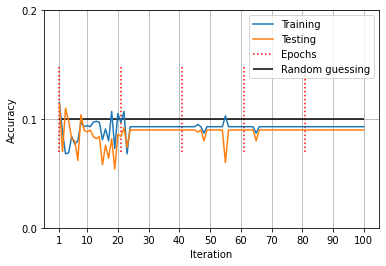

In [24]:
nn_plot_iter_acc(train_acc_dict["model_1"],
                 test_acc_dict["model_1"],
                 iteration_dict["model_1"],
                 mean_comparison = 0.1)

Hier jetzt das Modell mit den gemittelten Gewichten und Bias aus allen Partikel-Modellen.

In [25]:
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
init_model.set_weights(mean_weights)

In [26]:
init_model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 2ms/step - loss: 2.3035 - accuracy: 0.0900


[2.3034567832946777, 0.09000000357627869]

## Wir versuchen das gleiche mit der (falschen?) Jacobi-Matrix aus Tensorflow

In [27]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_acc_dict = {}
test_acc_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [28]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_acc_dict["model_{}".format(str(i+1))] = []
    test_acc_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [29]:
import tensorflow as tf

loss_fct = tf.keras.losses.CategoricalCrossentropy(reduction = "none")

In [30]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [X_train[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]   
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            y_batch_tf = tf.constant(y_batches[b])
            y_pred_tf = tf.Variable(y_pred_dict["model_{}".format(str(i+1))])
            
            with tf.GradientTape() as tape:
                loss_value = loss_fct(y_batch_tf, y_pred_tf)
            jacobian_tf = tape.gradient(loss_value, y_pred_tf)
            
            jacobian_dict["model_{}".format(str(i+1))] = jacobian_tf.numpy()
            
            # for every particle write the training accuracy of the current iteration in a dictionary
            train_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])
            
            # for every particle write the test accuracy of the current iteration in a dictionary
            test_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])
            
            # for every particle write the current iteration in a dictionary
            iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
        #print(y_pred_dict["model_1"])
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))
                                       
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))

In [31]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_val_small, y_val_small)[1])

16/16 [==============================] - 0s 3ms/step - loss: 84.8487 - accuracy: 0.0600
0.05999999865889549
16/16 [==============================] - 0s 2ms/step - loss: 72.2849 - accuracy: 0.0560
0.0560000017285347
16/16 [==============================] - 0s 2ms/step - loss: 68.9369 - accuracy: 0.0580
0.057999998331069946
16/16 [==============================] - 0s 2ms/step - loss: 2.3363 - accuracy: 0.1060
0.10599999874830246
16/16 [==============================] - 0s 2ms/step - loss: 91.7313 - accuracy: 0.0560
0.0560000017285347
16/16 [==============================] - 0s 2ms/step - loss: 2506001.5000 - accuracy: 0.0920
0.09200000017881393
16/16 [==============================] - 0s 2ms/step - loss: 41.4389 - accuracy: 0.0600
0.05999999865889549
16/16 [==============================] - 0s 2ms/step - loss: 78.5810 - accuracy: 0.0580
0.057999998331069946
16/16 [==============================] - 0s 3ms/step - loss: 67.0825 - accuracy: 0.0560
0.0560000017285347
16/16 [==================

In [32]:
model_dict["model_1"].get_weights()

[array([[-0.11831225,  0.10447012,  0.20371804, ..., -0.05139467,
         -0.148048  , -0.0540847 ],
        [-0.03169299,  0.06558982, -0.01399464, ...,  0.15486078,
         -0.04208934,  0.20781654],
        [ 0.13395163, -0.06884686, -0.12038681, ..., -0.1440718 ,
         -0.04637593, -0.08088905],
        ...,
        [ 0.07031509,  0.14459941, -0.11517407, ...,  0.03997347,
         -0.14098784,  0.05308264],
        [ 0.00719288, -0.09476507, -0.03475358, ...,  0.01640788,
         -0.0261506 , -0.01947559],
        [ 0.06903791, -0.08829751, -0.02466458, ...,  0.10137183,
          0.04548208, -0.17386521]], dtype=float32),
 array([ 5.5211291e-02, -8.3665021e-02,  3.5833664e-02, -1.3289483e-01,
         4.7131786e-01,  2.8080443e-01, -1.0507261e-01,  3.7511688e-01,
        -2.7342141e-01,  1.9491625e-01, -3.0210784e-01, -3.4661833e-04,
        -1.9284874e-01,  2.8593174e-01,  3.8662124e-02,  4.9371598e-03,
        -1.7477442e-01, -1.7920659e-01, -1.6291453e-01, -2.1268415e-01

In [33]:
y_pred_dict["model_1"]

array([[4.20191226e-14, 1.02624906e-13, 3.38217878e-32, 4.47423926e-16,
        8.09755484e-19, 6.12526890e-32, 0.00000000e+00, 1.00000000e+00,
        1.26611160e-15, 8.55945904e-16],
       [3.49197719e-11, 1.13308234e-11, 2.14054887e-17, 4.74465842e-29,
        3.03550900e-22, 0.00000000e+00, 0.00000000e+00, 1.55028971e-02,
        9.84497070e-01, 1.96757220e-15],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 2.01234680e-17, 0.00000000e+00, 0.00000000e+00,
        1.60554981e-20, 0.00000000e+00, 2.85452339e-14, 5.93279638e-28,
        0.00000000e+00, 1.71816693e-11],
       [9.99985814e-01, 1.41473383e-05, 0.00000000e+00, 4.40622495e-37,
        9.02681578e-31, 0.00000000e+00, 0.00000000e+00, 4.97692858e-24,
        2.92268222e-18, 2.48358084e-19],
       [1.00000000e+00, 5.59839962e-30, 0.00000000e+00, 0.00000000e+00,
   

In [34]:
jacobian_dict["model_1"]

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
   

In [35]:
train_acc_dict

{'model_1': [0.07900000363588333,
  0.07599999755620956,
  0.09200000017881393,
  0.06199999898672104,
  0.10999999940395355,
  0.1379999965429306,
  0.09799999743700027,
  0.10300000011920929,
  0.09600000083446503,
  0.11599999666213989,
  0.11500000208616257,
  0.09300000220537186,
  0.07400000095367432,
  0.061000000685453415,
  0.07000000029802322,
  0.06599999964237213,
  0.06300000101327896,
  0.08399999886751175,
  0.06800000369548798,
  0.07699999958276749,
  0.07500000298023224,
  0.0860000029206276,
  0.07900000363588333,
  0.0989999994635582,
  0.0989999994635582,
  0.10000000149011612,
  0.05900000035762787,
  0.08799999952316284,
  0.06300000101327896,
  0.05000000074505806,
  0.11599999666213989,
  0.10000000149011612,
  0.10000000149011612,
  0.0989999994635582,
  0.0989999994635582,
  0.06599999964237213,
  0.06800000369548798,
  0.06800000369548798,
  0.05299999937415123,
  0.09700000286102295,
  0.050999999046325684,
  0.0989999994635582,
  0.052000001072883606,
  0.

In [36]:
test_acc_dict

{'model_1': [0.09799999743700027,
  0.09600000083446503,
  0.10199999809265137,
  0.10599999874830246,
  0.12999999523162842,
  0.1340000033378601,
  0.11400000005960464,
  0.10999999940395355,
  0.10999999940395355,
  0.09799999743700027,
  0.10199999809265137,
  0.09000000357627869,
  0.0820000022649765,
  0.06400000303983688,
  0.05000000074505806,
  0.041999999433755875,
  0.06599999964237213,
  0.06800000369548798,
  0.06599999964237213,
  0.05999999865889549,
  0.05999999865889549,
  0.057999998331069946,
  0.06199999898672104,
  0.10999999940395355,
  0.10999999940395355,
  0.10999999940395355,
  0.06400000303983688,
  0.09600000083446503,
  0.05400000140070915,
  0.05400000140070915,
  0.1340000033378601,
  0.1080000028014183,
  0.10999999940395355,
  0.10999999940395355,
  0.10999999940395355,
  0.07199999690055847,
  0.0860000029206276,
  0.08799999952316284,
  0.05000000074505806,
  0.10199999809265137,
  0.05000000074505806,
  0.10999999940395355,
  0.05400000140070915,
  0

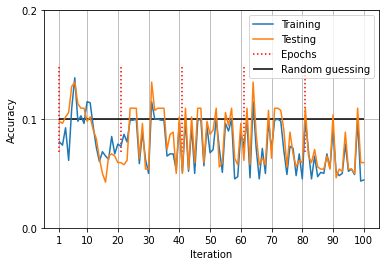

In [37]:
nn_plot_iter_acc(train_acc_dict["model_1"],
                 test_acc_dict["model_1"],
                 iteration_dict["model_1"],
                 mean_comparison = 0.1)